In this post, we will crawl world population data from Wikipedia and do some analysis. [The data is taken from this page](https://en.wikipedia.org/wiki/List_of_countries_by_past_and_future_population) provides us the population detail for every country on Earth every 5 years, from 1955 upto 2050. Yes! It also predicts what is the status of world population in the future. Please read the article to understand how the demographic grow is calculated.

**Note**: this is also an excercise from CS109 course by Havard University.

### Process
As any data analysis task, we will go through following steps:
- Data collection (web scraping) using **BeautifulSoup**
- Data wrangling (data cleaning & transformation) using **Numpy** and **Pandas**
- Data analysis by plotting graphs using **matplotlib** and **seaborn**

If you just want to read about the analysis, please scroll down to the end of this post.

### 1. Data collection
First, let's import necessary packages and libraries. Some libraries might be imported later when needed.

In [1]:
import sys
sys.path.append('/home/hoanvu/anaconda2/envs/ds/lib/python2.7/site-packages/')

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
from __future__ import division

sns.set_context('poster')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Configure the URL, get the contents and **soup** it:

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_countries_by_past_and_future_population'
req = requests.get(url)
soup = BeautifulSoup(req.content, 'html.parser')

The data given by the Wikipedia article is put inside 3 HTML tables:
- The first table contains population data from 1955 to 1980, every 5 years
- The second table contains population data from 1985 to 2015, every 5 years
- The third table contains population data from 2020 to 2050, every 5 years

We will crawl based on this information and put data for each table inside a pandas DataFrame. In the end, we will concatnate data from all 3 tables into a single DataFrame for the cleaning process.

I will not explain in detail the BeautifulSoup code, you might already played with this library several times (and if you read my previous blog posts [**here**](http://hoanvu.github.io/2016/05/scraping-jobs-from-vietnamworks) and [**here**](http://hoanvu.github.io/2016/06/vietnam-it-jobs-analysis), you will have the prerequisite to understand the code). But I will explain the steps I used to crawl the data (It took me quite a long time to figure out the right way to extract the table data anyway, though I'm not sure if it's the best strategy):

There are 3 tables, for each table:
- First extract the header, include Country Name and Year, used for header in pandas DataFrame
- Next, find all `tr` tags, we know that each row in the HTML table is represented by a `tr` tag
- Thirdly, for each `tr` tag, look for all `td` tags inside it
- Get the contents from inside `td` tags, append them to a Python `list`
- Append the above `list` into another 2D `list`
- This 2D list will be used to form our pandas DataFrame for each table
- Lastly, concatnate all 3 DataFrame to form a single DataFrame

In [3]:
# All 3 tables have the class 'sortable'
tables = soup.find_all('table', {'class': 'sortable'})

# 'population' is the final pandas DataFrame that contains all data
population = pd.DataFrame()
for table_dom in tables:
    # First, get the header for each table
    headers = []
    for header in table_dom.find_all('th'):
        headers.append(header.contents[0])
        
    # Next, get the data, 'data' is a 2D list used to store data for each table
    data = []
    # Find all tr tags inside each table
    for tr_tag in table_dom.find_all('tr'):
        row = []
        # Next, find all td tags inside a single tr tag
        row_data = tr_tag.find_all('td')
        if row_data:
            for index in xrange(len(row_data)):
                if index == 1:
                    row.append(row_data[index].find('a').contents[0])               
                else:
                    row.append(row_data[index].contents[0])

        if row:
            data.append(row)
    
    # Create the DataFrame based on the 2D list 'data'
    table_data = pd.DataFrame.from_records(np.array(data[:-1], dtype=object), columns=headers)
    
    # Concatnate each DataFrame with the 'population' DataFrame
    population = pd.concat([population, table_data], axis=1)

Let's take a look at our final DataFrame:

In [4]:
population.head()

,Nº,Country (or dependent territory),1950,1955,%,1960,%,1965,%,1970,...,2030,%,2035,%,2040,%,2045,%,2050,%
0,1,Afghanistan,"8,151","8,892",1.76,"9,830",2.03,"10,998",2.27,"12,431",...,"45,665",2.12,"50,195",1.91,"54,717",1.74,"59,256",1.61,"63,796",1.49
1,2,Albania,"1,228","1,393",2.56,"1,624",3.12,"1,884",3.02,"2,157",...,"3,103",-0.01,"3,063",-0.26,"2,994",-0.45,"2,913",-0.55,"2,825",-0.61
2,3,Algeria,"8,893","9,842",2.05,"10,910",2.08,"11,964",1.86,"13,932",...,"48,149",0.99,"50,118",0.80,"52,030",0.75,"53,894",0.71,"55,445",0.57
3,4,American Samoa,20,20,0.72,21,0.20,25,4.23,28,...,53,-0.32,52,-0.45,51,-0.45,50,-0.29,50,-0.06
4,5,Andorra,7,7,0.04,9,6.28,14,10.17,20,...,85,-0.21,83,-0.30,82,-0.46,79,-0.69,75,-0.93


In [5]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 47 columns):
Nº                                  227 non-null object
Country (or dependent territory)    227 non-null object
1950                                227 non-null object
1955                                227 non-null object
%                                   227 non-null object
1960                                227 non-null object
%                                   227 non-null object
1965                                227 non-null object
%                                   227 non-null object
1970                                227 non-null object
%                                   227 non-null object
1975                                227 non-null object
%                                   227 non-null object
1980                                227 non-null object
%                                   227 non-null object
Nº                                  227 non-null object

### 2. Data wrangling
At the end of collection steps, we had a DataFrame named `population` that contains all data we crawled from 3 tables inside the Wikipedia page. But by taking a glance at the DataFrame, we know that there are too many junk data (real-world data always is) that need to be removed. 

Here are few things that we will do to make our data cleaner for analysis:
- There are 3 columns which have same name (`Country (or dependent territory)`) and contains country names, which is redundant. We will remove 2 of them
- Make country name column to be the index for the DataFrame. This is very useful for the analysis process
- All columns named `%` describe how population changes compared to the last 5 years. I don't think this is necessary for our analysis, so just remove them. In your case, if you think this might bring some interesting insights, feel free to keep them.
- Wikipedia used comma (',') to separate between units like million or thousand. For example: 21,340 or 34,000,321. This makes the data more readable for our human, but computer will not understand this kind of notation, so just remove them.
- Convert data type to integer (default is string)

In [6]:
# Remove all duplicate and unnecessary columns

# This line removes all remaining unnecessary and duplicated columns name (with '%' and 'No' as header)
population = population.drop(population.columns[[0, 4]], axis=1)

# This line removes all duplicate columns with country name
population = population.T.drop_duplicates().T

# Rename the country name column
population['country_name'] = population['Country (or dependent territory)']
population = population.drop('Country (or dependent territory)', axis=1)

# Make 'country_name' as our new index
population = population.set_index('country_name')

# Delete all ',' (commas) in data to reflect true quantity
population = population.replace({',': ''}, regex=True)

# Convert data type for the DataFrame to 'int'
population = population.astype(int)

Now our data is much more cleaner and ready for analysis:

In [7]:
population.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227 entries, Afghanistan to Zimbabwe
Data columns (total 21 columns):
1950    227 non-null int64
1955    227 non-null int64
1960    227 non-null int64
1965    227 non-null int64
1970    227 non-null int64
1975    227 non-null int64
1980    227 non-null int64
1985    227 non-null int64
1990    227 non-null int64
1995    227 non-null int64
2000    227 non-null int64
2005    227 non-null int64
2010    227 non-null int64
2015    227 non-null int64
2020    227 non-null int64
2025    227 non-null int64
2030    227 non-null int64
2035    227 non-null int64
2040    227 non-null int64
2045    227 non-null int64
2050    227 non-null int64
dtypes: int64(21)
memory usage: 39.0+ KB


In [8]:
population.head()

,1950,1955,1960,1965,1970,1975,1980,1985,1990,1995,...,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
country_name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,8151,8892,9830,10998,12431,14133,15045,13120,13569,19446,...,26335,29121,32565,36644,41118,45665,50195,54717,59256,63796
Albania,1228,1393,1624,1884,2157,2402,2672,2957,3245,3159,...,3025,2987,3030,3075,3105,3103,3063,2994,2913,2825
Algeria,8893,9842,10910,11964,13932,16141,18807,22009,25191,28322,...,32918,35950,39543,42973,45842,48149,50118,52030,53894,55445
American Samoa,20,20,21,25,28,30,33,39,48,54,...,57,56,55,54,54,53,52,51,50,50
Andorra,7,7,9,14,20,27,34,45,53,64,...,77,85,86,86,86,85,83,82,79,75


### 3. Analysis

#### What is the general status of the world population since 1955?

- World population increase **almost 3 times** in 2015 (7.26 billions) since 1950 (2.56 billions)
- The world population will continue to increase in the future but has the tendency to raise slower. In 2050, the population is estimated to be **only 3.6 times** compared to 1950

World population in 1950: 2.56 billions.
World population in 2015: 7.26 billions.
World population in 2050: 9.41 billions.


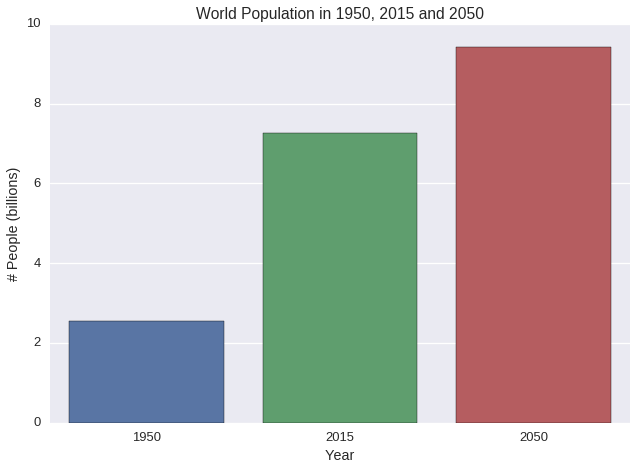

In [9]:
import matplotlib.ticker as tkr
from collections import defaultdict

world_population = defaultdict()
for col in population.columns:
    world_population[col] = population[col].sum()
    
world_population = pd.DataFrame(data=world_population, index=['World'])

sns.set_context('talk')
pop_1950 = round(world_population['1950'] / 1000000, 2)
pop_2015 = round(world_population['2015'] / 1000000, 2)
pop_2050 = round(world_population['2050'] / 1000000, 2)
ax = sns.barplot(x=['1950', '2015', '2050'], 
            y=[pop_1950, pop_2015, pop_2050])

print "World population in 1950: {} billions.".format(pop_1950)
print "World population in 2015: {} billions.".format(pop_2015)
print "World population in 2050: {} billions.".format(pop_2050)

ax.set(xlabel='Year', ylabel='# People (billions)', 
       title='World Population in 1950, 2015 and 2050')


The following graph shows the world population tendency in a better way:

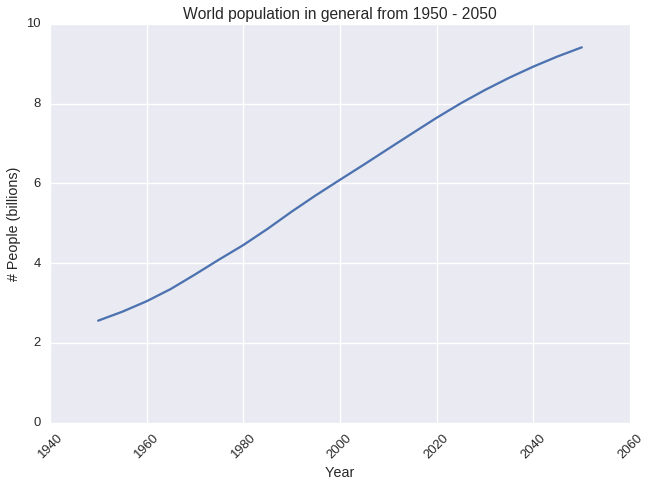

In [10]:
world = world_population.loc['World']
plt.plot(world.index, world / 1000000, label=world.name)
plt.xticks(rotation=45)
plt.ylim(ymin=0)
plt.xlabel('Year')
plt.ylabel('# People (billions)')
plt.title('World population in general from 1950 - 2050')

#### What are 5 most populous countries from 1950 to 2050?

- In 1950, 5 most populous countries are: China, India, United States, Russia and Japan
- In 2015, 5 most populous countries are: China, India, United States, Indonesia and Brazil
- In 2050, 5 most populous countries are: China, India, United States, Nigeria and Indonesia
- China, India and United States are always 3 most populous countries
- The population of China is predicted to start decreasing from 2025, the population of India and US continue to raise. Maybe India needs to research what China are planning to do to decrease their population

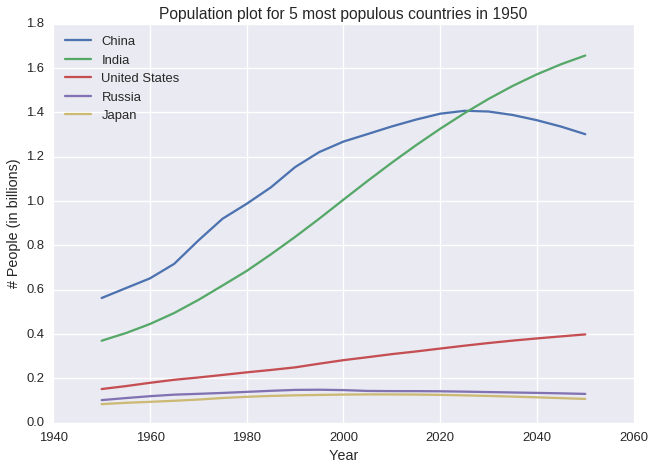

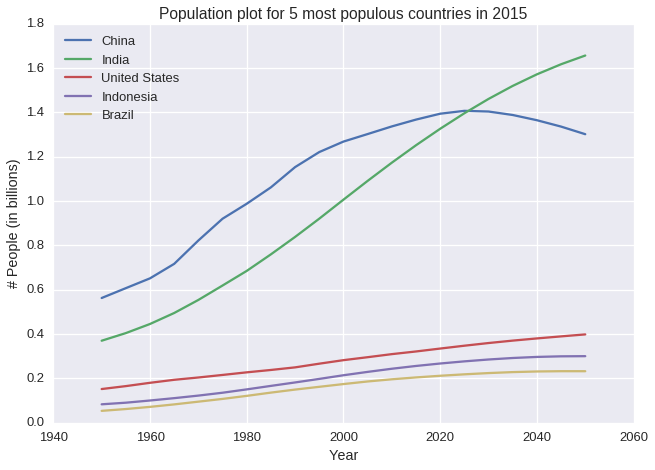

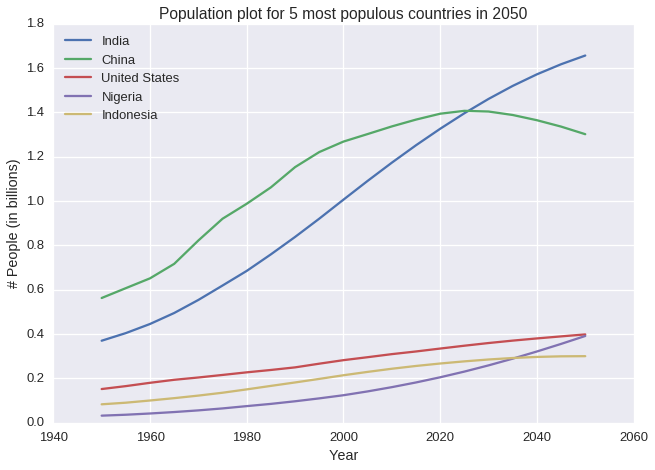

In [11]:
def plot_5_most_populous(data, year):
    pop_by_year = data.sort_values(year, ascending=False)
    
    plt.figure()
    for i in xrange(5):
        country = pop_by_year.iloc[i]
        plt.plot(country.index, country / 1000000, label=country.name)
    
    plt.ylim(ymin=0)
    plt.xlabel('Year')
    plt.ylabel('# People (in billions)')
    plt.legend(loc='best')
    plt.title('Population plot for 5 most populous countries in {}'.format(year))
    
plot_5_most_populous(population, '1950')
plot_5_most_populous(population, '2015')
plot_5_most_populous(population, '2050')

#### How about Vietnam, Laos, Thailand and Campuchia?

- Vietnam is the most populous country
- Vietnam's population is still increasing quickly in the next few decades and begins to slow down since 2015
- Thailand's population seems to raise very slowly and forecasted to start decreasing since 2030
- Populations of Cambodia and Laos are increasing but very slow

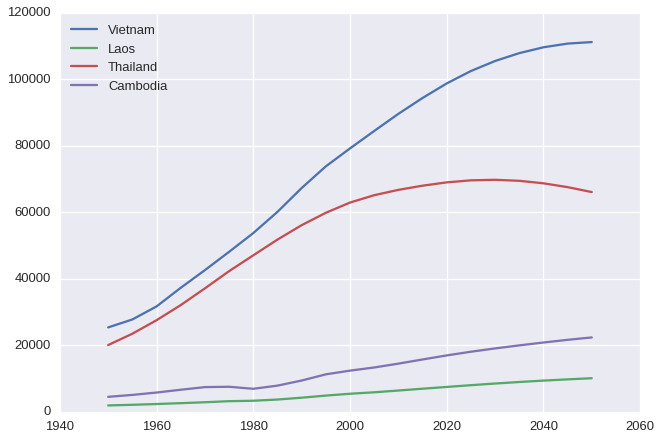

In [12]:
countries = ['Vietnam', 'Laos', 'Thailand', 'Cambodia']

for country in countries:
    country_data = population.loc[country]
    plt.plot(country_data.index, country_data, label=country_data.name)
    
plt.legend(loc='best')

#### How many countries in which the population is decreasing?

- There seems to have 62 countries which their population is decreasing now and in the future

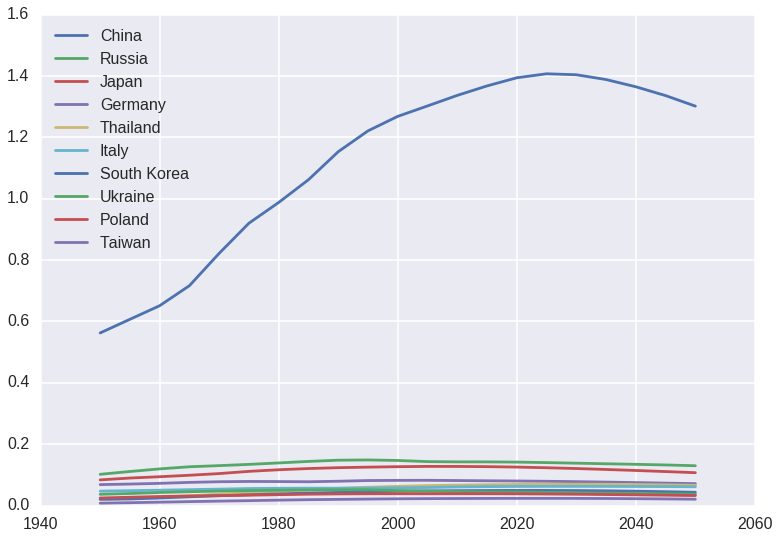

In [13]:
data = population[population['2050'] < population['2025']].sort_values('2025', ascending=False)
sns.set_context('poster')
plt.figure()
for i in xrange(10):
    country = data.iloc[i]
    #print country.index
    plt.plot(country.index, country / 1000000, label=country.name)
    
plt.legend(loc='best')    

**Look at China**! What are they planning to do to decrease their population to such an extent?